In [97]:
def sub_parts(c):
    """
    For a list c = [1,2,0], return
                  [[0,0,0],
                   [1,0,0],
                   [0,1,0],
                   [1,1,0],
                   [0,2,0],
            NEW:   c]
    """
    if len(c) == 1:
        return [[x] for x in range(c[0])]

    if c[0] == 0:
        return [[0] + y for y in sub_parts(c[1:])]

    d = sub_parts(c[1:])
    g = sub_parts([c[0]-1]+c[1:])+[[c[0]]+y for y in sub_parts(c[1:])]+[[c[0]-1]+c[1:]]
    return g+[c]

In [98]:
def exceptional(n):
    # Returns the exceptional Cartan matrix E_n, for n >= 5
    if n < 5:
        raise ValueError("Matrix E_n only makes sense for n >= 5")
    M = []
    for i in range(n):
        row = []
        for j in range(n):
            if i == j:
                row.append(2)
            elif (i == j + 1) or (j == i + 1):
                row.append(-1)
            elif ((i == n - 1) and (j == 2)) or ((j == n - 1) and (i == 2)):
                row.append(-1)
            else:
                row.append(0)
        M.append(row)
    M[n-1][n-2] = 0
    M[n-2][n-1] = 0
    return CartanMatrix(M)

In [102]:
class root(tuple):
    """
    The class for roots of a Kac-Moody algebra.
    """
    def __init__(self, list_form):
        self.list_form    = list(list_form)
        self.vector_form  = vector(list_form)
        self.tuple_form   = tuple(list_form)
        self.height       = sum(self.list_form)
        #self.coding       = prime_code(list_form)
    def __str__(self):
        return 'root'+str(self.list_form)
    def __repr__(self):
        return 'root'+str(self.list_form)
    #def __eq__(left, right):
    #    return left.coding == right.coding
    def __le__(left,right):
        return all(l <= r for l, r in zip(left.list_form, right.list_form))
    def __lt__(left,right):
        return all(l <= r for l, r in zip(left.list_form, right.list_form)) and not left == right
#     def height(self):
#         return sum(self.list_form)
#     def set_multiplicity(self, kma, m):
#         kma.multiplicities[self.coding] = m
#     def multiplicity(self, kma):
#         return kma.multiplicities[self.coding]
#     def set_c(self, kma, c):
#         kma.cs[self.coding] = c
#     def c(self, kma):
#         return kma.cs[self.coding] # REplace
    def __mul__(self,other):
        return self.vector_form * other
    def __rmul__(self,other):
        return other*self.vector_form
    def __sub__(self,other):
        return self.vector_form - other
    def __rsub__(self,other):
        return other - self.vector_form
    def __div__(self,other):
        return self.vector_form/other

In [257]:
class KacMoodyAlgebra():
    """
    The class for CartanMatrices decorated with more information.
    """
    def __init__(self, matrix, height=30):
        #Setup
        self.matrix = CartanMatrix(matrix)
        self.height = height
        self.dim = self.matrix.nrows()
        self.simple_roots = [root(tuple([int(a == b) for a in range(self.dim)])) for b in range(self.dim)]
        #self.roots = AVLTree()
        self.roots = set(self.simple_roots)
        self.multiplicities = dict()
        self.cs = dict()
        self.zero_root = root(tuple([0] * self.dim))
        
        
        #Calculation to height
        for s in self.simple_roots:
            #s.set_multiplicity(self, 1)
            #s.set_c(self, 1)
            self.multiplicities[s] = 1
            self.cs[s] = 1
        self.pingpong(self.simple_roots) # Generate real roots
        print('simple calculation done')
        
        #Now, figure out the imag
        self.imag_basis = [root(list(-x)) for x in Cone(matrix).dual().Hilbert_basis()]
        self.graded_ascent(height)
        
        

    def B(self, a, b):
        """
        Returns the bilinear product induced by self - does this work for nonsymmetric?
        """
        return a * self.matrix * b

    def weyl(self, r, s):
        """
        Acts the Weyl group representation of the simple root s on the root r r
        """
        return root(r - self.B(r, s) * s)

    def pingpong(self, generators):
        """
        Adjoin all the roots, that can be obtained
        by acting the Weyl group on the generators, up to height
        """
        #self.roots.insert_list(generators)
        for g in generators:
            to_pingpong = [g]
            #mult = g.multiplicity(self)
            mult = self.multiplicities[g]
            c    = self.cs[g]
            while len(to_pingpong) != 0:
                next_root    = to_pingpong.pop()
                ponged       = [self.weyl(next_root, s) for s in self.simple_roots]
                qonged       = [p for p in ponged if p.height <= self.height and self.zero_root <= p]
                #below is test for f.d. case
                #qonged       = [p for p in ponged if p.height() <= self.height and not p in self.roots]
                #to_pingpong += qonged
                for p in qonged:
                    if p not in self.roots:
                        to_pingpong.append(p)
                        #p.set_multiplicity(self, mult)
                        self.multiplicities[p] = mult
                        self.cs[p] = c
                        self.roots.add(p)
                    
    def peterson(self,r):
        #recurse
        pass
    
    def graded_ascent(self,height):
        """
        for now; do something naive; if we are summing to height
        """
        _temp = sub_parts([floor(height/r.height) for r in self.imag_basis])[1:]
        _toloop = []
        for x in _temp:
            _temp2 = sum([self.imag_basis[i]*x[i] for i in range(len(x))])
            if sum(_temp2) <= height and root(list(_temp2)) not in _toloop:
                _toloop.append(root(list(_temp2)))
        _toloop = sorted(_toloop,key=lambda r: r.height)

        for r in _toloop:
            """
            Theres a subtelty here; we only store roots with mult > 0; but
            there are 'pseudo-roots' which have mult = 0 but c > 0 (multiples of real roots)
            
            For now; we deal with this in a slightly hackish way
            """
            
            #First, pick out all the roots which are less than the root of interest
            _tosum = [s for s in self.roots if s < r]
            #print(len(_tosum))
            _temp = 0
            dealt_with = []
            
            for s_i in range(len(_tosum)):
                
                #Check if we have been dealt with
                if s_i in dealt_with:
                    #print('got dealt with',_tosum[s_i])
                    continue
                
                #First, find the base root associated
                s = _tosum[s_i]
                s = root(tuple(s/divisors(gcd(s.list_form))[-1]))
                
                for n in range(1,floor(r.height/s.height)+1):
                    #Now, scale the base root
                    _s = root(tuple(n*s))
                    
                    #Check if this scaled version is contained elsewhere
                    if _s in _tosum and _s != _tosum[s_i]:
                        #EXCEPT IN THE SPECIAL CASE THEY ARE ALL ON THE SAME LINE?!?!?
                        #if _s in [root(list(r/n)) for n in divisors(gcd(r.list_form))]:
                        #    continue
                        #Actually, ^that is not an exception
                        dealt_with.append(_tosum.index(_s))
                        #print('wild',n,s,_s,s_i,_tosum.index(_s))
                        #print('what is going on',_tosum[383])
                    
                    #Now, need to check that the complement is a pseudoroot/root
                    _poss = [(root(tuple((r-_s)/m)),m) for m in divisors(gcd(_s.list_form))]
                    for _pt in _poss:
                        _p = _pt[0]
                        if _p in self.roots:
                            #The complement, divided by m, is a root; so its a pseudoroot
                            _tempc = 0; _tempc2 = 0;
                            for o in divisors(gcd(_s.list_form)):
                                if root(tuple(_s/o)) in self.roots:
                                    #print('huh')
                                    _tempc = _tempc + self.multiplicities[root(tuple(_s/o))]/o
                            for o in divisors(gcd(list(r-_s))):
                                if root(tuple((r-_s)/o)) in self.roots:
                                    #print('wuh')
                                    _tempc2 = _tempc2 + self.multiplicities[root(tuple((r-_s)/o))]/o
                            
                            #if _tempc == 0 or _tempc2 == 0:
                            #    print('huh')
                            #_tempc = sum([self.multiplicities[root(tuple(_s/o))]/o for o in divisors(gcd(_s.list_form))])
                            #_tempc2= sum([self.multiplicities[root(tuple(_p/o))]/o for o in divisors(gcd(_p.list_form))])/_pt[1]
                            _temp = _temp + _tempc*_tempc2*self.B(_s,r-_s)
                            #if s == root([2, 4, 6, 5, 4, 3, 2, 1, 0, 3]):
                            #    print('yohoho',n)
                            break
            
            self.cs[r] = _temp/(self.B(r,r) - 2*r.height)
            #self.cs[r] = sum([self.cs[s]*self.cs[root(list(r-s))]*self.B(s,r-s) for s in _tosum])/(self.B(r,r) - 2*r.height)
            self.multiplicities[r] = self.cs[r] - sum([self.multiplicities[root(tuple(r/n))]/n for n in divisors(gcd(r.list_form))[1:]])
            self.roots.add(r)
            self.pingpong([r])
            print(r,r.height,self.B(r,r),self.multiplicities[r])
        
        
        
    

In [244]:
K = KacMoodyAlgebra(exceptional(10),height=80)
len([r for r in K.roots if r.height <= 61])

simple calculation done


3433

In [251]:
KacMoodyAlgebra(exceptional(10),height=61)

simple calculation done
240
(root[2, 4, 6, 5, 4, 3, 2, 1, 0, 3], 30, 0, 8)
481
('yohoho', 1)
(root[4, 8, 12, 10, 8, 6, 4, 2, 0, 6], 60, 0, 8)
1789
('yohoho', 1)
('wild', 2, root[2, 4, 6, 5, 4, 3, 2, 1, 0, 3], root[4, 8, 12, 10, 8, 6, 4, 2, 0, 6], 201, 297)
('yohoho', 2)
('got dealt with', root[4, 8, 12, 10, 8, 6, 4, 2, 0, 6])
(root[4, 8, 12, 10, 8, 6, 4, 2, 1, 6], 61, -2, 44)


<__main__.KacMoodyAlgebra instance at 0x21e458170>

In [256]:
KacMoodyAlgebra(exceptional(10),height=76)

simple calculation done
240
(root[2, 4, 6, 5, 4, 3, 2, 1, 0, 3], 30, 0, 8)
481
('yohoho', 1)
(root[4, 8, 12, 10, 8, 6, 4, 2, 0, 6], 60, 0, 8)
1789
('wild', 1, root[2, 4, 6, 5, 4, 3, 2, 1, 0, 3], root[2, 4, 6, 5, 4, 3, 2, 1, 0, 3], 383, 642)
('what is going on', root[4, 8, 12, 10, 8, 6, 4, 2, 0, 6])
('yohoho', 1)
('yohoho', 2)
('got dealt with', root[2, 4, 6, 5, 4, 3, 2, 1, 0, 3])
(root[4, 8, 12, 10, 8, 6, 4, 2, 1, 6], 61, -2, 44)
6566
('wild', 2, root[2, 4, 7, 6, 5, 4, 3, 2, 1, 3], root[4, 8, 14, 12, 10, 8, 6, 4, 2, 6], 199, 366)
('what is going on', root[3, 6, 10, 7, 6, 4, 3, 2, 1, 5])
('wild', 1, root[2, 4, 6, 5, 4, 3, 2, 2, 1, 3], root[2, 4, 6, 5, 4, 3, 2, 2, 1, 3], 329, 5005)
('what is going on', root[3, 6, 10, 7, 6, 4, 3, 2, 1, 5])
('got dealt with', root[4, 8, 14, 12, 10, 8, 6, 4, 2, 6])
('wild', 2, root[2, 4, 6, 6, 5, 4, 3, 2, 1, 3], root[4, 8, 12, 12, 10, 8, 6, 4, 2, 6], 445, 1674)
('what is going on', root[3, 6, 10, 7, 6, 4, 3, 2, 1, 5])
('wild', 1, root[2, 4, 6, 5, 4, 4, 3, 2

<__main__.KacMoodyAlgebra instance at 0x220d2afc8>

In [258]:
KacMoodyAlgebra(exceptional(10),height=100)

simple calculation done
(root[2, 4, 6, 5, 4, 3, 2, 1, 0, 3], 30, 0, 8)
(root[4, 8, 12, 10, 8, 6, 4, 2, 0, 6], 60, 0, 8)
(root[4, 8, 12, 10, 8, 6, 4, 2, 1, 6], 61, -2, 44)
(root[4, 9, 14, 12, 10, 8, 6, 4, 2, 7], 76, -4, 192)
(root[6, 12, 18, 15, 12, 9, 6, 3, 0, 9], 90, 0, 8)
(root[6, 12, 18, 15, 12, 9, 6, 3, 1, 9], 91, -4, 192)
(root[6, 12, 18, 15, 12, 9, 6, 4, 2, 9], 93, -6, 5805/8)


<__main__.KacMoodyAlgebra instance at 0x22426cf80>

In [199]:
KacMoodyAlgebra(exceptional(10),height=90)

simple calculation done
(root[2, 4, 6, 5, 4, 3, 2, 1, 0, 3], 30, 0, 8)
(root[4, 8, 12, 10, 8, 6, 4, 2, 0, 6], 60, 0, 5)
('wild', root[4, 8, 12, 10, 8, 6, 4, 2, 0, 6])
(root[4, 8, 12, 10, 8, 6, 4, 2, 1, 6], 61, -2, 5435/124)
('wild', root[4, 8, 12, 10, 8, 6, 6, 4, 2, 6])
('wild', root[4, 8, 12, 10, 8, 6, 4, 2, 0, 6])
('wild', root[4, 8, 12, 10, 8, 6, 4, 4, 2, 6])
('wild', root[4, 8, 12, 10, 8, 8, 6, 4, 2, 6])
('wild', root[4, 8, 14, 12, 10, 8, 6, 4, 2, 6])
('wild', root[4, 8, 12, 10, 8, 6, 4, 2, 2, 6])
('wild', root[4, 8, 12, 10, 8, 6, 4, 4, 2, 6])
('wild', root[4, 8, 14, 12, 10, 8, 6, 4, 2, 6])
('wild', root[4, 8, 12, 10, 10, 8, 6, 4, 2, 6])
('wild', root[4, 8, 12, 10, 8, 8, 6, 4, 2, 6])
('wild', root[4, 8, 12, 10, 8, 6, 6, 4, 2, 6])
('wild', root[4, 8, 12, 10, 10, 8, 6, 4, 2, 6])
('wild', root[4, 8, 12, 10, 8, 6, 4, 2, 2, 6])
('wild', root[4, 8, 12, 12, 10, 8, 6, 4, 2, 6])
(root[4, 9, 14, 12, 10, 8, 6, 4, 2, 7], 76, -4, 79234/403)
('wild', root[4, 8, 12, 10, 8, 6, 4, 2, 0, 6])
(root[6

<__main__.KacMoodyAlgebra instance at 0x1fe467dd0>

In [26]:
#Lookup time comparison
def random_tuple_generator(n,h):
    """
    generates random tuples of length n and height h
    """
    return tuple([random.random()*h for i in range(n)])

In [47]:
list_times = []
set_times = []

for q in range(30,50,3):
    p = q/10
    big_list = [random_tuple_generator(5,10) for i in range(floor(10**p))]
    big_set = set(big_list)
    to_sample = [big_list[randint(0,floor(10**p)-1)] for i in range(1000)]
    print('ok')
    
    start = time.time()
    for g in to_sample:
        if g in big_list:
            pass
    end = time.time()
    list_times.append(end-start)

    start = time.time()
    for g in to_sample:
        if g in big_set:
            pass
    end = time.time()
    set_times.append(end-start)
        
    print(p)


ok
3
ok
33/10
ok
18/5
ok
39/10
ok
21/5
ok
9/2
ok
24/5


In [49]:
import matplotlib.pyplot as plt

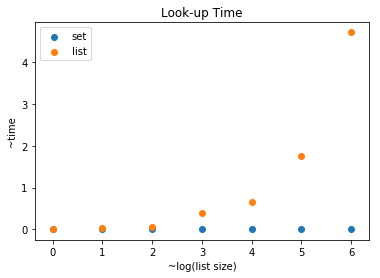

In [54]:
plt.title('Look-up Time')
plt.scatter(range(len(set_times)),set_times,label='set')
plt.scatter(range(len(set_times)),list_times,label='list')
plt.xlabel('~log(list size)')
plt.legend()
plt.ylabel('~time')
plt.show()